In [35]:
import matplotlib
matplotlib.use('nbAgg')  # Use notebook backend
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


INFO:scene_setup:Starting scene setup with ray tracing...


XLA can lead to reduced numerical precision. Use with care.


DEBUG:scene_setup:Debugging Base station state:
DEBUG:scene_setup:- Position: [10.  10.   4.5]
DEBUG:scene_setup:- Orientation: [  0.   0. -90.]
DEBUG:scene_setup:- Array config: <sionna.rt.antenna_array.PlanarArray object at 0x000001F82DD17550>
DEBUG:scene_setup:Debugging RIS state:
DEBUG:scene_setup:- Position: [10.  19.5  2.5]
DEBUG:scene_setup:- Orientation: [  0. -90.   0.]
DEBUG:scene_setup:Debugging AGV_0 state:
DEBUG:scene_setup:- Position: [12.   5.   0.5]
DEBUG:scene_setup:- Orientation: [0. 0. 0.]
DEBUG:scene_setup:- Array config: <sionna.rt.antenna_array.PlanarArray object at 0x000001F838549250>
DEBUG:scene_setup:Debugging AGV_1 state:
DEBUG:scene_setup:- Position: [ 8.  15.   0.5]
DEBUG:scene_setup:- Orientation: [0. 0. 0.]
DEBUG:scene_setup:- Array config: <sionna.rt.antenna_array.PlanarArray object at 0x000001F82DE814D0>
INFO:scene_setup:Scene setup completed successfully
INFO:scene_setup:- Transmitters: 7
INFO:scene_setup:- Receivers: 2
INFO:scene_setup:- RIS: 1
INFO:sc

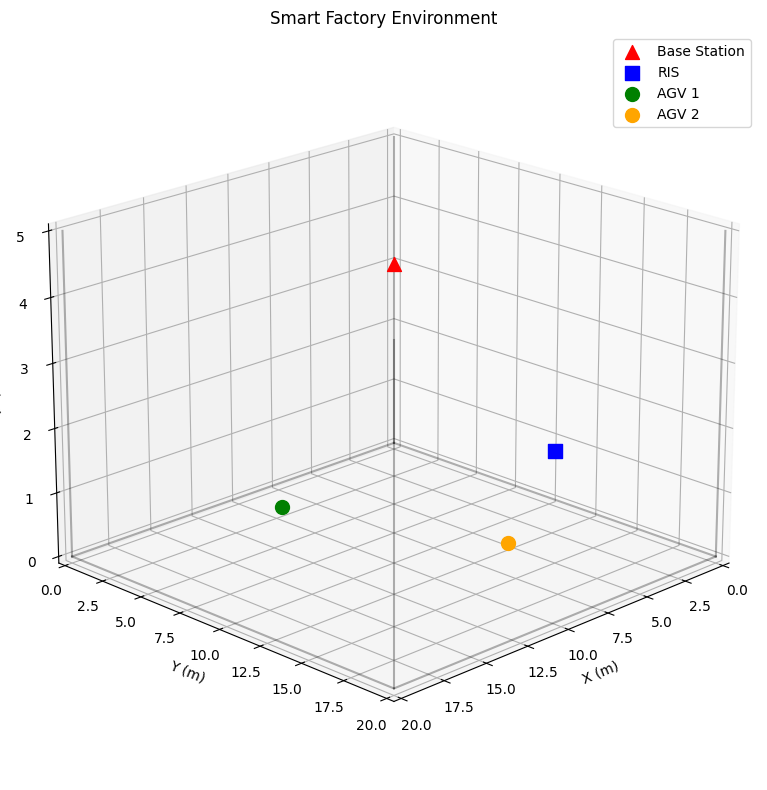

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from channel_generator import SmartFactoryChannel
from config import SmartFactoryConfig

def visualize_factory_scene(scene):
    """Visualize the factory scene with all components"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot Base Station
    bs_pos = scene.transmitters['bs'].position.numpy()
    ax.scatter(bs_pos[0], bs_pos[1], bs_pos[2], c='red', marker='^', s=100, label='Base Station')
    
    # Plot RIS
    ris_pos = scene.ris['ris'].position.numpy()
    ax.scatter(ris_pos[0], ris_pos[1], ris_pos[2], c='blue', marker='s', s=100, label='RIS')
    
    # Plot AGVs
    colors = ['green', 'orange']
    for i, rx in enumerate(scene.receivers.values()):
        pos = rx.position.numpy()
        ax.scatter(pos[0], pos[1], pos[2], c=colors[i], marker='o', s=100, 
                  label=f'AGV {i+1}')
    
    # Plot room boundaries
    room_dim = config.room_dim
    ax.plot([0, room_dim[0]], [0, 0], [0, 0], 'k-', alpha=0.3)
    ax.plot([0, 0], [0, room_dim[1]], [0, 0], 'k-', alpha=0.3)
    ax.plot([room_dim[0], room_dim[0]], [0, room_dim[1]], [0, 0], 'k-', alpha=0.3)
    ax.plot([0, room_dim[0]], [room_dim[1], room_dim[1]], [0, 0], 'k-', alpha=0.3)
    
    # Add vertical lines at corners
    for x in [0, room_dim[0]]:
        for y in [0, room_dim[1]]:
            ax.plot([x, x], [y, y], [0, room_dim[2]], 'k-', alpha=0.3)
    
    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Smart Factory Environment')
    
    # Set axis limits
    ax.set_xlim([0, room_dim[0]])
    ax.set_ylim([0, room_dim[1]])
    ax.set_zlim([0, room_dim[2]])
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Adjust view angle for better visualization
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    return fig

# Create configuration and initialize channel generator
config = SmartFactoryConfig()
channel_gen = SmartFactoryChannel(config)

try:
    # Visualize the scene
    fig = visualize_factory_scene(channel_gen.scene)
    plt.show()
    
    # Optional: Save the figure
    # fig.savefig('factory_scene.png', dpi=300, bbox_inches='tight')
    
except Exception as e:
    print(f"Error during visualization: {str(e)}")
    import traceback
    traceback.print_exc()

In [37]:
scene.preview() 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [38]:
# First verify your scene is loaded correctly
scene = load_scene("factory_scene.xml")
print(scene.get_objects())  # This should list all objects in your scene

NameError: name 'load_scene' is not defined

In [39]:
import os
import tensorflow as tf
import numpy as np
from sionna.rt import Scene, load_scene, Camera
import matplotlib.pyplot as plt
from sionna.rt import Transmitter, Receiver
import mitsuba as mi

# Set the Mitsuba variant to use
mi.set_variant('scalar_rgb')

# Create a new scene
scene = Scene()

# Define materials
material_concrete = {
    "type": "diffuse",
    "reflectance": [0.539479, 0.539479, 0.539480]
}

material_metal = {
    "type": "diffuse",
    "reflectance": [0.8, 0.8, 0.8]
}

# Add materials to scene
mat_concrete = scene.add_material("concrete", material_concrete)
mat_metal = scene.add_material("metal", material_metal)

# Add shapes from PLY files
meshes_dir = "meshes"  # Directory containing your PLY files
scene.add_shape("floor", f"{meshes_dir}/floor.ply", mat_concrete)
scene.add_shape("ceiling", f"{meshes_dir}/ceiling.ply", mat_concrete)
scene.add_shape("wall_xp", f"{meshes_dir}/wall_xp.ply", mat_concrete)
scene.add_shape("wall_xm", f"{meshes_dir}/wall_xm.ply", mat_concrete)
scene.add_shape("wall_yp", f"{meshes_dir}/wall_yp.ply", mat_concrete)
scene.add_shape("wall_ym", f"{meshes_dir}/wall_ym.ply", mat_concrete)

# Add a transmitter (BS)
tx = Transmitter(name="tx",
                position=[5.0, 5.0, 2.0],
                orientation=[0.0, 0.0, 0.0])
scene.add(tx)

# Add a receiver (UE)
rx = Receiver(name="rx",
             position=[15.0, 15.0, 1.5],
             orientation=[0.0, 0.0, 0.0])
scene.add(rx)

# Set the frequency
scene.frequency = 3.5e9  # 3.5 GHz

# Add cameras for different views
cameras = {
    "top": Camera("top_view", position=[10.0, 10.0, 20.0]),
    "side": Camera("side_view", position=[30.0, 10.0, 5.0]),
    "corner": Camera("corner_view", position=[20.0, 20.0, 10.0])
}

# Add cameras to scene and set their look_at points
for cam in cameras.values():
    scene.add(cam)
    cam.look_at([10.0, 10.0, 0.0])

# Compute paths using ray tracing
paths = scene.compute_paths(max_depth=3,
                          method="image",
                          los=True,
                          reflection=True,
                          diffraction=True,
                          scattering=False)

# Create a figure with multiple subplots for different views
plt.figure(figsize=(15, 5))

# Render and display different camera views
for i, (name, camera) in enumerate(cameras.items(), 1):
    plt.subplot(1, 3, i)
    img = scene.render(camera)
    plt.imshow(img)
    plt.title(f"{name} view")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print path information
print("\nPath Information:")
print(f"Number of paths: {paths.n_paths}")
if paths.n_paths > 0:
    print(f"Path lengths: {paths.lengths}")
    print(f"Number of interactions: {paths.n_interactions}")
    
# Visualize ray paths
plt.figure(figsize=(10, 10))
paths.show()
plt.title("Ray Paths")
plt.show()

# Get channel impulse response
a, tau = paths.cir()

# Plot channel impulse response
plt.figure(figsize=(10, 5))
plt.stem(tau[0,0,0].numpy(), np.abs(a[0,0,0].numpy()))
plt.xlabel('Delay [s]')
plt.ylabel('Magnitude')
plt.title('Channel Impulse Response')
plt.grid(True)
plt.show()

AttributeError: 'Scene' object has no attribute 'add_material'

In [42]:
import os
import tensorflow as tf
import numpy as np
from sionna.rt import Scene, load_scene, Camera
import matplotlib.pyplot as plt
from sionna.rt import Transmitter, Receiver
import mitsuba as mi

# Set the Mitsuba variant to use
mi.set_variant('scalar_rgb')

# Load your custom scene
scene = Scene("src/factory_scene.xml")

# Add a transmitter (BS)
tx = Transmitter(name="tx",
                position=[5.0, 5.0, 2.0],
                orientation=[0.0, 0.0, 0.0])
scene.add(tx)

# Add a receiver (UE)
rx = Receiver(name="rx",
             position=[15.0, 15.0, 1.5],
             orientation=[0.0, 0.0, 0.0])
scene.add(rx)

# Set the frequency
scene.frequency = 3.5e9  # 3.5 GHz

# Add cameras for different views
cameras = {
    "top": Camera("top_view", position=[10.0, 10.0, 20.0]),
    "side": Camera("side_view", position=[30.0, 10.0, 5.0]),
    "corner": Camera("corner_view", position=[20.0, 20.0, 10.0])
}

# Add cameras to scene and set their look_at points
for cam in cameras.values():
    scene.add(cam)
    cam.look_at([10.0, 10.0, 0.0])

# Compute paths using ray tracing
paths = scene.compute_paths(max_depth=3,
                          method="image",
                          los=True,
                          reflection=True,
                          diffraction=True,
                          scattering=False)

# Create a figure with multiple subplots for different views
plt.figure(figsize=(15, 5))

# Render and display different camera views
for i, (name, camera) in enumerate(cameras.items(), 1):
    plt.subplot(1, 3, i)
    img = scene.render(camera)
    plt.imshow(img)
    plt.title(f"{name} view")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print path information
print("\nPath Information:")
print(f"Number of paths: {paths.n_paths}")
if paths.n_paths > 0:
    print(f"Path lengths: {paths.lengths}")
    print(f"Number of interactions: {paths.n_interactions}")
    
# Visualize ray paths
plt.figure(figsize=(10, 10))
paths.show()
plt.title("Ray Paths")
plt.show()

# Get channel impulse response
a, tau = paths.cir()

# Plot channel impulse response
plt.figure(figsize=(10, 5))
plt.stem(tau[0,0,0].numpy(), np.abs(a[0,0,0].numpy()))
plt.xlabel('Delay [s]')
plt.ylabel('Magnitude')
plt.title('Channel Impulse Response')
plt.grid(True)
plt.show()

RuntimeError: ​[xml.cpp:1377] "src\factory_scene.xml": file does not exist!